In [24]:
%load_ext autoreload
%autoreload 2

from einops import rearrange
from text3d2video.wandb_util import MVFeaturesArtifact
import wandb
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from text3d2video.wandb_util import AnimationArtifact, first_logged_artifact_of_type, first_used_artifact_of_type


api = wandb.Api({
    'entity': 'romeu',
    'project': 'diffusion-3D-features'
})

mv_features_art = 'multiview_features:latest'

mv_features_art = api.artifact(f'romeu/diffusion-3D-features/{mv_features_art}')
mv_features_art = MVFeaturesArtifact(mv_features_art)

mv_featuers_run = mv_features_art.artifact.logged_by()
animation_art = first_used_artifact_of_type(mv_featuers_run, AnimationArtifact.type)
animation_art = AnimationArtifact(animation_art)

mesh = animation_art.get_mesh()

wandb:   19 of 19 files downloaded.  
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.3


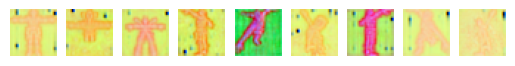

In [83]:
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil

features = mv_features_art.get_features()
all_features = torch.stack(features)

all_features = rearrange(all_features, 'v c h w -> (v h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features)

features_rgb = [pca.feature_map_to_rgb(feature) for feature in features]

N = len(features_rgb)
fig, ax = plt.subplots(1, N)
for i in range(N):
    ax[i].imshow(features_rgb[i].permute(1,2,0))
    ax[i].axis('off')

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, na

/home/jorge/thesis/text3d2video/visualization.py:44: RuntimeWarning: invalid value encountered in divide
  reduced[:, c] = (reduced[:, c] - minval) / (maxval - minval)


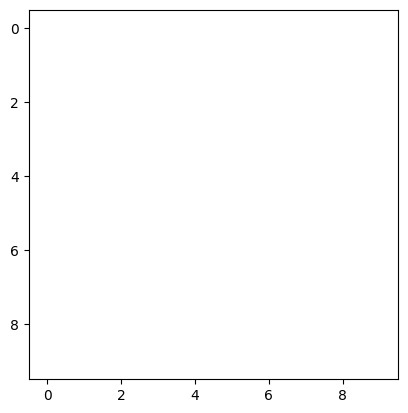